
<img src="logo_gfz.jpg" alt="GFZ-Potsdam" style="width: 200px;"/>

# Risk-oriented, bottom-up modelling of building portfolios with faceted taxonomies 
### Implementation of fuzzy scoring to assign building vulnerability classes starting from faceted taxonomy descriptions. 
#### Massimiliano Pittore, Michael Haas, Konstantinos G. Megalooikonomou and Vitor Silva

 Copyright © GFZ-Potsdam 2018
 
#### Disclaimer: 
 This code is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

The present code is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

### introduction

The following notebook implements the methodology described in the companion paper "Risk-oriented, bottom-up modelling of building portfolios with faceted taxonomies" Pittore et al., 2018.

The methodology aims at classifying an unknown building based on its taxonomic description according to the GEM taxonomy v2.0 (Brzev et al., 2013).

**NOTE**: Besides Python2 the notebook requires several packages which can be installed using the file 'requirements.txt'
          
          pip install -r requirements.txt

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Basic operations on triangular fuzzy numbers (TFN)

A triangular fuzzy number (TFN, see, e.g., Dhutta et al.,2011) is hereby defined as an array of three real numbers $[n_1,n_2,n_3]$; the first describes the value with the highest membership, i.e. the mode of the distribution. The second and third numbers represent the support of the fuzzy number, i.e. the interval outside which its membership is zero ($n_1 \in [n_2,n_3]$). The membership function will be then linearly increasing from 0 at $n_2$ to 1 at $n_1$, and then will linearly decrease from 1 at $n_1$ to 0 at $n_3$.

In the following a few basic operations with TFNs are defined.

See e.g., Dhutta et al. (2011),Fuzzy Arithmetic with and without using
α-cut method: A Comparative Study.
International Journal of Latest Trends in Computing (E-ISSN: 2045-5364) 
99 Volume 2, Issue 1, March 2011

In [3]:

def fuzzy_sum(a,b,ac=1,bc=1):
    '''
    Weighted sum of two triangular fuzzy numbers. implements:
    sum = ac*a + bc*b
    'ac' and 'bc' are the (real-valued) multiplicative coefficient 
    of the two summands 'a' and 'b'. 
    '''
    #a,b: triangular fuzzy numbers
    #ac,bc: coefficients (multiplicative)
    # equivalent to d = ac*a + bc*b
    d = [ac*a[0]+bc*b[0],ac*a[1]+bc*b[1],ac*a[2]+bc*b[2]]
    return d

def defuzzify(a,method='mode'):
    '''
    turn a triangular fuzzy number into a crisp number (i.e., a single real value). 
    Mode may take the following values: 'mode','mean','median', 
    indicating the respective statistical descriptors considering the TFN as 
    a piecewise linear probability density.
    '''
    r = 0
    if (method=='mode'):
        r = a[0]
    elif (method=='mean'):
        r = sum(a)/3.0
    elif (method=='median'):
        if (a[0]>=(a[1]+a[2])/2.0):
            r = a[1]+np.sqrt((a[2]-a[1])*(a[0]-a[1])/2.0)
        else:
            r = a[2]-np.sqrt((a[2]-a[1])*(a[2]-a[0])/2.0)
    else:
        raise NumError('unrecognized method: {}'.format(method))
    return r


def fuz_greater(a,b):
    '''
    Compute the degree of membership of the relation "a > b"
    between two triangular fuzzy numbers.
    after:
    D. Dorohonceanu and A. Marin (2002) Simple Method for Comparing Fuzzy Numbers, and
    A. S. Dadgostar, A Decentralized Reactive Fuzzy Scheduling System for 
    Cellular Manufacturing Systems, 
    Ph.D. Thesis, University of South Wales, Australia, 1996.
    
    NOTE: crisp inputs are not supported
    '''
    dsum=dsuml=0
    for p in np.arange(0,1,0.2):
        i_a = [a[1]+p*(a[0]-a[1]),a[2]-p*(a[2]-a[0])]
        i_b = [b[1]+p*(b[0]-b[1]),b[2]-p*(b[2]-b[0])]
        d = (i_a[1]-i_b[0]) / (i_b[1]-i_b[0]+i_a[1]-i_a[0])
        if d>1: d=1
        if d<0: d=0
        dl = (i_b[1]-i_b[0])*(i_a[1]-i_a[0])
        dsum = dsum+d*dl
        dsuml = dsuml+dl
        assert abs(dsuml)>1e-8,'error, crisp numbers are not supported'
    return dsum/dsuml

def fuz_argmax(fvec,mThresh=0.5):
    '''
    implement argmax of a list of fuzzy numbers 'fvec'.
    'mThresh' is the threshold on the degree of membership of 
    the 'greater than' relation in order to consider the number actually greater.
    '''
    ind1=0
    ind2=1
    for step in range(1,len(fvec)):
        if fuz_greater(fvec[ind1],fvec[ind2])<mThresh:
            ind1 = ind2
        ind2 = ind2+1
    return ind1


## Functions to draw triangular fuzzy numbers

Auxiliary functions to plot one or more TFNs. 

In [4]:
from matplotlib.pyplot import figure, show, cm
from matplotlib.patches import Polygon

def plot_fnum(fnumlist):
    '''
    Plot a list of triangular fuzzy numbers as triangles (polygons)
    '''
    plt.figure()
    ax = plt.gca()

    for fnum in fnumlist:
        print fnum
        poly = get_tripoly(fnum)
        p = Polygon(poly,closed=True,color='red',alpha=0.2,fill=False)
        ax.add_patch(p)

    ax.set_xlim(-1,1)
    plt.show()

def get_tripoly(f_num):
    '''
    auxiliary. Turns a triangular fuzzy number into a polygon 
    '''
    poly = [[f_num[1],0],[f_num[0],1],[f_num[2],0]]
    return poly

def plot_v_fnum(ax,fnum, xx, width,alpha):
    '''
    plots a triangular fuzzy number 'fnum' on a predefined axix 'ax' at a x-coord 'xx'
    as a rectangular patch with gradient fill, opacity 'alpha' and width 'width'. 
    Also overlay three defuzzified estimates. It needs the auxiliary 
    function 'defuzzify'.
    '''
    Xup = [[1, 1], [.0, .0]]
    Xdown = [[.0, .0], [1, 1]]
    ax.imshow(Xdown, interpolation='quadric', cmap=cm.Blues,vmin=0,vmax=1,
                      extent=(xx-width, xx+width, fnum[0],fnum[2]), alpha=alpha)
    ims = ax.imshow(Xup, interpolation='quadric', cmap=cm.Blues,vmin=0,vmax=1,
                      extent=(xx-width, xx+width, fnum[1],fnum[0]), alpha=alpha)
    mode=defuzzify(fnum,'mode')
    median=defuzzify(fnum,'median')
    mean=defuzzify(fnum,'mean')
    hl1 = ax.hlines(y=mode, xmin=xx-width, xmax=xx+width,alpha=alpha)
    hl2 = ax.hlines(y=median, xmin=xx-width, xmax=xx+width,alpha=alpha,linestyle='dashed')
    hl3  = ax.hlines(y=mean, xmin=xx-width, xmax=xx+width,alpha=alpha,linestyle='dotted')
    return ims


def plot_fnum_vec(fnum_list,fnum_lab,figfilename='',alpha=0.5,rot=0,ha ='center',loc='upper right'):
    '''
    Plots a list of triangular fuzzy nubers 'fnum_list', with respective
    labels 'fnum_lab'. 'alpha' is the level of opacity, 'rot' the rotation of the x labels,
    'ha' is the location of the x-labels with respect to the theoretic position, 
    'loc' is the location of the legend. 
    if 'figfilename' is defined then is used as path and filename to save the figure.
    Needs the auxiliary function plot_v_fnum.
    '''
    fig = figure()
    bar_width = 0.5

    n_groups= len(fnum_list)
    ax = fig.add_subplot(111, xlim=[bar_width/2,n_groups+bar_width], ylim=[-1,1],
                         autoscale_on=False)

    ax.set_xticks(np.arange(n_groups) + 1)
    ax.set_xticklabels(fnum_lab,rotation=rot,ha=ha)
    
    ims = 0
    for i,fnum in enumerate(fnum_list):
        ims = plot_v_fnum(ax,fnum,i+1,0.25,alpha)
    
    ax.set_aspect('auto')
    ax.legend(('mode','median','mean'),loc=loc)
    cbar = fig.colorbar(ims,orientation='vertical')
    plt.ylabel('compatibility score')
    plt.xlabel('compatibility level (fuzzy)')
    if (figfilename):
        plt.tight_layout()
        print 'saving fig {}'.format(figfilename)
        plt.savefig(figfilename,dpi=300)    
    plt.show()
    show()


## Fuzzy compatibility levels

Let us define two sets of compatibility levels expressed as triagular fuzzy numbers (TFN).
Both are composed by 7 compatibility levels: 
- highly compatible
- moderately compatible
- slightly compatible
- neutral
- slightly incompatible
- moderately incompatible
- highly incompatible

these are used to encode into a fuzzy representation the degree of compatibility of an attribute value with respect to a reference class.


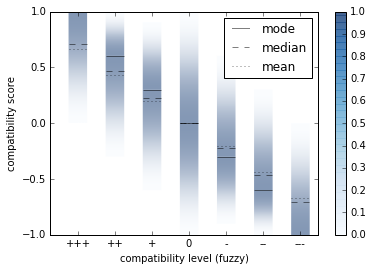

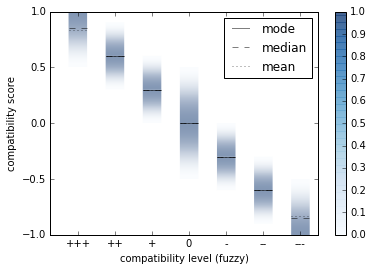

In [5]:
import collections

#more uncertain
mf=collections.OrderedDict()
mf['+++'] = [1,0,1]  # highly compatible
mf['++'] = [0.6,-0.3,1]  # moderately compatible
mf['+'] = [0.3,-0.6,0.9] # slightly compatible
mf['0'] = [0,-1,1]  # neutral
mf['-'] =  [-0.3,-0.9,0.6] # slightly incompatible
mf['--'] = [-0.6,-1,0.3]  # moderately incompatible
mf['---'] = [-1,-1,0]   # highly incompatible

#more sharp
mf2=collections.OrderedDict()
mf2['+++'] = [1,0.5,1]  # highly compatible
mf2['++'] = [0.6,0.3,0.9]  # moderately compatible
mf2['+'] = [0.3,0,0.6] # slightly compatible
mf2['0'] = [0,-0.5,0.5]  # neutral
mf2['-'] =  [-0.3,-0.6,0] # slightly incompatible
mf2['--'] = [-0.6,-0.9,-0.3]  # moderately incompatible
mf2['---'] = [-1,-1,-0.5]   # highly incompatible

#plot the two fuzzy compatibility level sets
plot_fnum_vec(mf.values(),mf.keys())
plot_fnum_vec(mf2.values(),mf2.keys())

## Fuzzy Compatibility Scores

This section provides the functions to evaluate the fuzzy scores for a single building or a list of buildings against one or more building classes. 
The functions accept as input the class definition schema, the attribute weights and the description of the fuzzy levels.

* * *

For each building a score $S$ will be assigned, defined as:

$$ S(b) = \sum_i w_i ( \sum_k \delta_{ik}(b) s_k) $$

where

$$   
\delta_{ik}(b) =\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ v_k \in B(b) \\
    0, & \text{otherwise}
  \end{array}\right.
$$


The score is based on the building type dictionary defined below, for each building tye

The score $S$ is then subject to the constraints $C_i$, aggregated such that:

$$ C = \prod_i \delta_{i}(b)$$

where

$$   
\delta_{i}(b) =\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ C_i \ \text{is satisfied}\ \\
    0, & \text{otherwise}
  \end{array}\right.
$$

---

In this case, a single constraint is defined for the height numerical attribute. 



In [6]:
# function that computes the score of a building for a building type
def compute_single_bscore_fuzzy(bdg,btype,wgsScheme, bmodScheme,fuzcompScheme, bDefuz=False, defuzMode='mode'):
    '''
    Computes the fuzzy score of a single building 'bdg' against a reference
    building type 'btype', according to a specific weighting scheme
    'wgs_scheme' and a building definition scheme 'bmod_scheme'. Also needs the definition 
    of a set of fuzzy compatbility levels 'fuzcompScheme'. If the booleab 'bDefuz' is True 
    then a crisp value is returned as score according to the defuzzifcation mode 'defuzMode'.
    The default compatibility value for attribute values not included in the
    class definition schema is '0' (neutral).
    The height is automtically considered as a constraint. If the constraint is not 
    verified, the final score is set to '---' (highly incompatible).
    '''
    #compute the compatibility score. Default comp value is '0', i.e. neutral
    s=[0,0,0]
    for k in wgsScheme.keys():
        a = fuzcompScheme[bmodScheme[btype][k].get(bdg[k],'0')]
        s = fuzzy_sum(s,a,1,wgsScheme[k])
    
    #check the additional attribute, in this case the height
    ch1 = True
    if (bdg['height_1'] != 'NO_DATA'):
        cs1 = ((bdg['height_1'] >= bmodScheme[btype]['height_1']['H_MIN']) & 
               (bdg['height_1'] <= bmodScheme[btype]['height_1']['H_MAX']))
    
    #apply the constraint. 
    #if the constraint is not fulfilled the resulting
    #score is set to 'highly incompatible'
    if (cs1 == False):
        s= fuzcompScheme['---']

    if bDefuz:
        score = defuzzify(s,defuzMode)
        return score
    else:
        return s

def compute_bscore_fuzzy(bdg, wgsScheme, bmodScheme,fuzcompScheme,bDefuz=False, defuzMode='mode'):
    '''
    Computes the scores for the building 'bdg', against all building 
    types defined in the class definition scheme 'bmodScheme'.
    Also needs the definition of a set of fuzzy compatbility levels 'fuzcompScheme'. 
    If the booleab 'bDefuz' is True then a crisp value is returned as score 
    according to the defuzzifcation mode 'defuzMode'.
    The default compatibility value for attribute values not included in the
    class definition schema is '0' (neutral).
    The height is automtically considered as a constraint. If the constraint is not 
    verified, the final score is set to '---' (highly incompatible).
    '''
    res={}
    for bt in bmodScheme.keys():
        res[bt]=compute_single_bscore_fuzzy(bdg,bt, wgsScheme, bmodScheme,fuzcompScheme,bDefuz,defuzMode) 
        res['object_id']=bdg['object_id']
    return res

def compute_expo_model_fuzzy(bdgs_set, wgsScheme, bmodScheme, fuzcompScheme, bFilterScore = True,bFilterScoreThreshold = 0, bDefuz=False, defuzMode='mode'):
    '''
    Applies the fuzzy scoring defined by the components 'wgs_schema','bmod_schema'
    to the buildings set 'bdgs_set'. 
    Returns the final exposure model and separately the scores for all
    buildings in 'bdgs_set'.
    if 'bFilterScore' is set to True, the 'not Valid' buildings (i.e., those whose fuzzy 
    score is smaller than 'bFilterScoreThreshold') are associated 
    to the 'OTH' building type.
    
    Returns the input buildings set with the respective assigned class, 
    and an additional dataframe with all the scores of the buildings with respect
    to the classes defined by the class definition scheme.
    '''
    #compute the score for each building in the dataframee
    scores = pd.DataFrame([compute_bscore_fuzzy(b, wgsScheme, bmodScheme,fuzcompScheme,False, defuzMode) for i,b in bdgs_set.iterrows()])
    
    # assign to each building the argmax of the score and 
    # set a flag to 'true' for the buildings whose best score is >= threshold
    if (bDefuz):
        scores['btype']=scores[bmodScheme.keys()].idxmax(1)
        scores['valid'] = scores.apply(lambda df:df[df['btype']]>bFilterScoreThreshold, 1)
    else:
        scores['btype'] = [bmodScheme.keys()[fuz_argmax(x.tolist())] 
             for ind,x in scores[bmodScheme.keys()].iterrows()]
        scores['valid'] = scores.apply(lambda df:defuzzify(df[df['btype']])>bFilterScoreThreshold, 1)

    #select only the valid ones ?
    if (bFilterScore):
        #the building type 'OTH' groups all the entries whose assignment was invalid
        for it, bd in scores[scores['valid']==False].iterrows():
            scores.set_value(it,'btype','OTH')
            bd['btype']='OTH'

    expo_df = pd.merge(bdgs_set,scores[['object_id','btype']], how='inner', on='object_id')
    return expo_df,scores

## Plotting the class definition schema

Functions to provide a synthetic graphical representation of a class definition schema in form of a gridded matrix.

In [7]:
def create_bmod_matrix(bmodScheme,wgsScheme,fuzcompScheme):
    '''
    Auxiliary funtion. 
    Creates a matrix with as many rows
    as the defined building types, and as many columns as
    the number of the attribute values explicitly rated in terms
    of compatibility value. The compatibility values 
    are defuzzified using the 'mode' to be colormapped accordingly.
    '''
    bmod_mat = pd.DataFrame(columns=['btype','attribute_type','attribute_val','score'])
    for bt in bmodScheme.keys():
        for k in wgsScheme.keys():
            for av in bmodScheme[bt][k]:
                a = fuzcompScheme[bmodScheme[bt][k][av]]
                s= defuzzify(a,'mode')
                bmod_mat = bmod_mat.append({'btype':bt, 
                                            'attribute_type':k,
                                'attribute_val':'{} : {}'.format(k,av),
                                                               'score':s},ignore_index=True)
            
    bmod_mat['score'] = pd.to_numeric(bmod_mat['score'])
    return bmod_mat

def plot_bclass_schema(bmodScheme, wgsScheme,fuzcompScheme,figfilename=''):
    '''
    Plots the class definition scheme 'bmodScheme' in form of a matrix with as many rows
    as the defined building types, and as many columns as
    the number of the attribute values explicitly rated in terms
    of compatibility value. The defuzzified compatibility value (as mode)
    is shown with a colormap.
    Uses the auxiliary function 'create_bmod_matrix'.
    '''
    bmod_mat = create_bmod_matrix(bmodScheme,wgsScheme,fuzcompScheme)
    bmod_mat_piv = bmod_mat.pivot('btype','attribute_val','score')
    f, ax = plt.subplots(figsize=(18, 8))
    sns.heatmap(bmod_mat_piv,vmin=-1, vmax=1,
                cmap=sns.color_palette("coolwarm", 7),linecolor='gray',
                    linewidth=0.1,xticklabels=1,ax=ax)
    if (figfilename):
        print 'saving fig {}'.format(figfilename)
        plt.tight_layout()
        plt.savefig(figfilename,dpi=300)
        plt.show()
    show()


## Serialization of the class definition schemas

In order to make the procedure more friendly, the class definition schema is serialized using simple text-based formats. This is exemplified using both the JSON (www.json.org) and the YAML (www.yaml.org) formats, which allow for a textual description that can be manually modified.

In [8]:
import yaml
import json
import os

def exportClassDict(classdict,filename, output_format = 'json'):
    '''
    Exports a class definition schema (in form of a dictionary) into a text file. 
    possible extensions are '.json' and '.yml' / '.yaml'
    '''
    pre, ext = os.path.splitext(filename)
    if (output_format == 'json'):
        output = json.dumps(classdict)
        filename=pre+'.json'
    elif (output_format == 'yaml') | (output_format == 'yml'):
        output = yaml.dump(classdict, default_flow_style=False, explicit_start=True)
        filename=pre+'.yml'
    else:
        raise NameError('unrecognized output_format: {}'.format(output_format))
    outf = open(filename,'w')
    outf.write(output)
    outf.close()

def importClassDict(filename):
    '''
    import a class definition schema into a dictionary. 
    possible extensions are '.json' and '.yml' / '.yaml'
    '''
    pre, ext = os.path.splitext(filename)
    inf = open(filename,'r')

    if ((ext == '.yml') | (ext == '.yaml')):
        cdict = yaml.load(inf.read())
    elif (ext == '.json'):
        cdict = json.loads(inf.read(), object_pairs_hook=OrderedDict)
    else:
        inf.close()
        raise NameError('Unrecognized extension: {}'.format(ext))
    inf.close()
    return cdict


## Define EMS-98 class definition schema

We define here the class definition schema that implements the vulnerability classes described in the EMS-98 original formulation (Grünthal et al.,1998).

| building type | description | GEM tax string         
| :- |:-------------: | :---------------------------------------------------:
|MUR1|rubble stone|MUR+STRUB+MOM/LN/FW+FW1+FWCN
|ADO|adobe|MUR+ADO+MOM/LN/FW+FW1+FWCN
|MUR2|simple stone|MUR+ST99+MOL/LN/FW+FW1+FWCN
|MUR3|massive stone|MUR+ST99+MOL/LN/FW+FW1+FWCN
|MUR4|unreinforced masonry with manifactured stone units|MUR+ST99+MOCL/LN/FW+FW1+FWCN
|MUR5|unreinforced masonry with RC floors|MUR+MO+MOC/LN/FC
|MR|reinforced or confined masonry|M99/FC+FC2+FWCP
|RC1|reinforced concrete frame without earthquake-resistant design (ERD)|CR+CIP/LN/FC+FC2+FWCP
|RC2|reinforced concrete frame with moderate earthquake-resistant design (ERD)|CR+CIP/LFM/FC+FC2+FWCP
|RC3|reinforced concrete frame with high level of earthquake-resistant design (ERD)|CR+CIP/LFINF+DUC/FC+FC2+FWCP
|RC4|reinforced concrete walls without ERD|CR+CIP/LWAL+DNO/FC+FC2+FWCP
|RC5|reinforced concrete walls with moderate level of ERD|CR+CIP/LWAL/FC+FC2+FWCP
|RC6|reinforced concrete walls with high level of ERD|CR+CIP/LWAL+DUC/FC+FC2+FWCP
|STEEL|steel structures|S/FME
|WOOD|timber structures|W/FW



In order the class assignment completely reproducible, we define contextually also the set of weights for the attribute types, and the compatibility levels in terms of TFNs.

The definition of this class definition schema is completely independent from a particular set of observations

The class definition schema is then assigned a set of basic metadata and serialized into a simple text file in a format that can be later parsed back. 

sum of values: 1.0


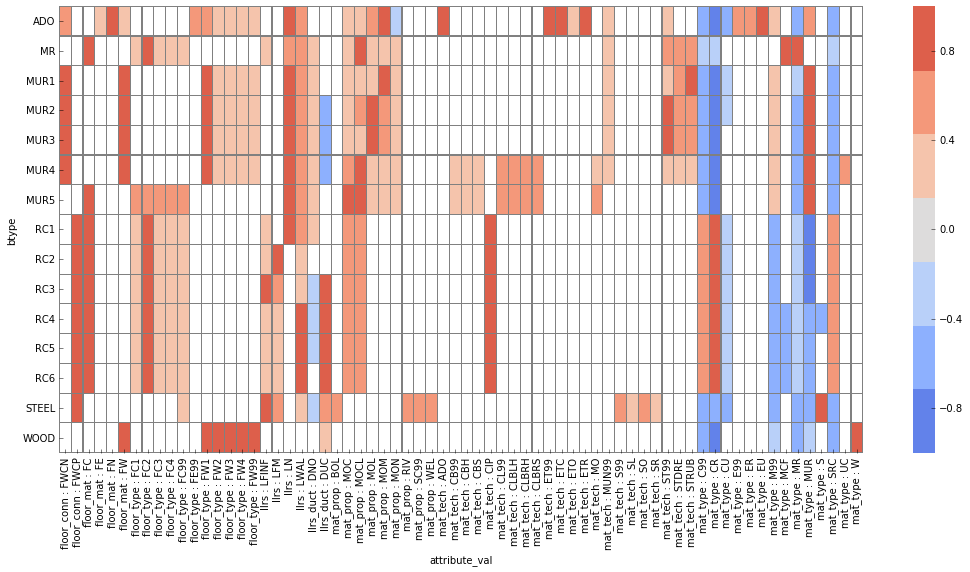

In [9]:
#define the weights 
wgs_ems98 = collections.OrderedDict()

wgs_ems98['mat_type'] = 0.35
wgs_ems98['mat_tech'] = 0.1
wgs_ems98['mat_prop'] = 0.05
wgs_ems98['llrs'] = 0.2
wgs_ems98['llrs_duct'] = 0.1
wgs_ems98['floor_mat'] = 0.1
wgs_ems98['floor_type'] = 0.05
wgs_ems98['floor_conn'] = 0.05

# check if sum of values is "1"
print "sum of values:", sum(wgs_ems98.values())

#define the classes
bmod_schema_ems98 = {
'ADO': 
 {'floor_mat': {'FW': '+', 'FE': '+', 'FN': '+++'}, 
  'floor_conn': {'FWCN': '++'}, 
  'mat_prop': {'MON': '-', 'MOM': '+++', 'MOL': '++', 'MOC': '+', 'MOCL': '+'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, 
  'llrs_duct': {}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 1}, 
  'floor_type': {'FW4': '+', 'FE99': '++', 'FW99': '+', 'FW3': '+', 'FW1': '++', 'FW2': '+'}, 
  'mat_type': {'M99': '+', 'E99': '++', 'MUR': '++', 'EU': '+++', 'ER': '++',
              'SRC': '--', 'CR': '---', 'CU': '--','C99': '--','MR': '--'}, 
  'mat_tech': {'ETR': '+++', 'ET99': '+++', 'ST99': '+', 'MUN99': '+', 'ETC': '+++', 
               'ADO': '+++','ETO': '+'}
 }, 
 'MUR1': 
 {'floor_mat': {'FW': '+++'},
  'floor_conn': {'FWCN': '+++'}, 
  'mat_prop': {'MON': '+', 'MOM': '+++', 'MOL': '+', 'MOC': '+', 'MOCL': '+'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, 
  'llrs_duct': {'DNO': '+'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 5}, 
  'floor_type': {'FW4': '+', 'FW99': '+', 'FW3': '+', 'FW1': '+++', 'FW2': '+'}, 
  'mat_type': {'M99': '+', 'MUR': '+++','MR': '-','SRC': '--', 'CR': '---', 'C99': '--',
              'SRC': '--', 'CR': '---', 'C99': '--', 'CU': '-'}, 
  'mat_tech': {'STDRE': '++', 'ST99': '+', 'STRUB': '+++', 'MUN99': '+'}
 }, 
 'MUR2': 
 {'floor_mat': {'FW': '+++'}, 
  'floor_conn': {'FWCN': '+++'}, 
  'mat_prop': {'MON': '+', 'MOM': '++', 'MOL': '+++', 'MOC': '+', 'MOCL': '++'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, 
  'llrs_duct': {'DNO': '+', 'DUC': '--'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 5}, 
  'floor_type': {'FW4': '+', 'FW99': '+', 'FW3': '+', 'FW1': '+++', 'FW2': '+'}, 
  'mat_type': {'M99': '+', 'MUR': '+++','SRC': '--', 'CR': '---', 'C99': '--',
              'SRC': '--', 'CU': '-','MR': '--'}, 
  'mat_tech': {'STDRE': '++', 'ST99': '+++', 'STRUB': '++', 'MUN99': '+'}
 }, 
 'MUR3': 
 {'floor_mat': {'FW': '+++'}, 
  'floor_conn': {'FWCN': '+++'}, 
  'mat_prop': {'MON': '+', 'MOM': '++', 'MOL': '+++', 'MOC': '+', 'MOCL': '+'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, 
  'llrs_duct': {'DNO': '+', 'DUC': '--'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 5}, 
  'floor_type': {'FW4': '+', 'FW99': '+', 'FW3': '+', 'FW1': '+++', 'FW2': '+'}, 
  'mat_type': {'M99': '+', 'MUR': '+++','MR': '--','SRC': '--', 'CR': '---', 'C99': '--'}, 
  'mat_tech': {'STDRE': '++', 'ST99': '+++', 'STRUB': '++', 'MUN99': '+'}
 },
 'MUR4': 
 {'floor_mat': {'FW': '+++'}, 
  'floor_conn': {'FWCN': '+++'}, 
  'mat_prop': {'MON': '+', 'MOM': '+', 'MOL': '+', 'MOC': '++', 'MOCL': '+++'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, 
  'llrs_duct': {'DNO': '+', 'DUC': '--'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 5}, 
  'floor_type': {'FW4': '+', 'FW99': '+', 'FW3': '+', 'FW1': '+++', 'FW2': '+'}, 
  'mat_type': {'M99': '+', 'MUR': '+++','UC': '++','SRC': '--', 'CR': '---',
               'C99': '--','MR': '--'}, 
  'mat_tech': {'ST99': '+', 'CLBRS': '++', 'CBH': '+', 'CBS': '+', 'CLBLH': '++', 
               'MUN99': '+', 'STDRE': '+', 'CLBRH': '++', 'CB99': '+', 'STRUB': '+','MO': '+','CL99': '++'}
 }, 
 'MUR5': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {}, 
  'mat_prop': {'MON': '+', 'MOM': '+', 'MOL': '+', 'MOC': '+++', 'MOCL': '+++'}, 
  'llrs': {'LN': '+++', 'LWAL': '++'}, 
  'llrs_duct': {'DNO': '+'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 6}, 
  'floor_type': {'FC1': '++', 'FC2': '++', 'FC3': '++', 'FC4': '++', 'FC99': '++'}, 
  'mat_type': {'M99': '+', 'MUR': '+++','SRC': '--', 'CR': '---', 
               'MR': '--','C99': '--'}, 
  'mat_tech': {'CLBRS': '++', 'CBH': '+', 'CLBLH': '++','CBS': '+', 
               'CLBRH': '++', 'CB99': '+', 'MO': '++','CL99': '++'}
 }, 
 'MR':
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {}, 
  'mat_prop': {'MON': '+', 'MOM': '+', 'MOL': '+', 'MOC': '+', 'MOCL': '+++'}, 
  'llrs': {'LN': '++', 'LWAL': '++', 'LFINF': '+'}, 
  'llrs_duct': {'DNO': '+'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 6}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'MCF': '+++', 'MR': '+++','SRC': '-', 'CR': '-', 'C99': '-'}, 
  'mat_tech': {'STDRE': '++', 'ST99': '++', 'STRUB': '++', 'MUN99': '+'}
 }, 
 'RC1': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LN': '+++', 'LWAL': '++', 'LFINF': '+'}, 
  'llrs_duct': {'DNO': '+'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 12}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++','CU': '-',
              'M99': '--', 'MUR': '---','MR': '-'}, 
  'mat_tech': {'CIP': '+++'}
 }, 
 'RC2': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LFM': '+++', 'LWAL': '+', 'LFINF': '+'}, 
  'llrs_duct': {}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 12}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++','CU': '-',
              'M99': '--', 'MUR': '---','MR': '-'}, 
  'mat_tech': {'CIP': '+++'}
 }, 
 'RC3': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LFM': '++', 'LWAL': '+', 'LFINF': '+++'}, 
  'llrs_duct': {'DNO': '-', 'DUC': '+++'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 12}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++', 'CU': '-',
              'M99': '--', 'MUR': '---','MR': '-'}, 
  'mat_tech': {'CIP': '+++'}
 },
 'RC4': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LFM': '+', 'LWAL': '+++', 'LFINF': '+'}, 
  'llrs_duct': {'DNO': '-', 'DUC': '+++'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 12}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++', 'CU': '-', 'S': '--',
              'M99': '--', 'MR': '-','MCF': '--','MUR': '--'}, 
  'mat_tech': {'CIP': '+++'}
 }, 
 'RC5': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LFM': '+', 'LWAL': '+++', 'LFINF': '+'}, 
  'llrs_duct': {'DNO': '-', 'DUC': '+++'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 12}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++','CU': '-',
              'M99': '--', 'MR': '-','MCF': '--','MUR': '--'}, 
  'mat_tech': {'CIP': '+++'}
 }, 
 'RC6': 
 {'floor_mat': {'FC': '+++'}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'MOC': '++', 'MOCL': '++'}, 
  'llrs': {'LFM': '+', 'LWAL': '+++', 'LFINF': '+'}, 
  'llrs_duct': {'DUC': '+++'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 24}, 
  'floor_type': {'FC1': '+', 'FC2': '+++', 'FC3': '+', 'FC4': '+', 'FC99': '+'}, 
  'mat_type': {'SRC': '++', 'CR': '+++', 'C99': '++', 'CU': '-',
              'M99': '--', 'MR': '-','MCF': '--','MUR': '--'}, 
  'mat_tech': {'CIP': '+++'}
 }, 
 'WOOD': 
 {'floor_mat': {'FW': '+++'}, 
  'floor_conn': {}, 
  'mat_prop': {}, 
  'llrs': {}, 
  'llrs_duct': {'DUC': '+'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 5}, 
  'floor_type': {'FW4': '+++', 'FW99': '+++', 'FW3': '+++', 'FW1': '+++', 'FW2': '+++'}, 
  'mat_type': {'W': '+++','SRC': '--', 'CR': '---', 'C99': '--',
              'M99': '-', 'MUR': '-','MR': '--'}, 
  'mat_tech': {}
 }, 
'STEEL': 
 {'floor_mat': {}, 
  'floor_conn': {'FWCP': '+++'}, 
  'mat_prop': {'SC99': '++', 'BOL': '++', 'RIV': '++', 'WEL': '++'}, 
  'llrs': {'LFM': '++', 'LWAL': '+', 'LFINF': '+++'}, 
  'llrs_duct': {'DUC': '++','DNO': '-'}, 
  'height_1': {'H_MIN': 1, 'H_MAX': 24}, 
  'floor_type': {'FC99': '+'}, 
  'mat_type': {'S': '+++','CR': '--','SRC': '--','C99': '--','CU': '--',
               'M99': '--','MUR': '--','MR': '--'}, 
  'mat_tech': {'SO': '++', 'SL': '+', 'SR': '+', 'S99': '++'}
 }
}

#fuzzy compatibility values
fuzComp_ems98=collections.OrderedDict()
fuzComp_ems98['---']= [-1, -1, 0] 
fuzComp_ems98['--']= [-0.6, -1, 0.3]
fuzComp_ems98['-']= [-0.3, -0.9, 0.6]
fuzComp_ems98['0']= [0, -1, 1]
fuzComp_ems98['+']= [0.3, -0.6, 0.9]
fuzComp_ems98['++']= [0.6, -0.3, 1]
fuzComp_ems98['+++']= [1, 0, 1]

#set the metadata to serialize the class definition schema
bmod_ems98_meta = collections.OrderedDict()
bmod_ems98_meta['name'] = 'bmod_ems98'
bmod_ems98_meta['description'] = 'definition of EMS-98 building types, using fuzzy compatibility formulation'
bmod_ems98_meta['version'] = '1.0'
bmod_ems98_meta['classes'] = bmod_schema_ems98.keys()
bmod_ems98_meta['weights'] = wgs_ems98
bmod_ems98_meta['fuzzy_values'] = fuzComp_ems98
bmod_ems98_meta['definition']= bmod_schema_ems98

#NOTE: we use ordered dicts but the order is not guaranteed
#      when loading the structure from a json / yaml file

#save file ? 
#outf = "path/filename.yml"
#exportClassDict(bmod_ems98_meta,outf,output_format='json')

#plot schema
plot_bclass_schema(bmod_schema_ems98,wgs_ems98,fuzComp_ems98)

## Load data from file

In order to create a risk-oriented exposure model we load a raw dataset from an external .csv file.

The building data refers to a mostly residential biuilding portfolio randomly selected in a location between Rittershofen and Soultz-sous-fôrets, in Alsace (France) where a geothermal plant is located.

The empty entries are replaced by a 'NO_DATA' value.


In [11]:
infile_destress = 'RRVS_survey_Alsace_Destress_21032018.csv'
bdg_df_destress = pd.read_csv(infile_destress).fillna('NO_DATA')

#print the first rows to peek at the data
bdg_df_destress.head()

,lon,lat,object_id,mat_type,mat_tech,mat_prop,llrs,llrs_duct,height,height_1,...,roof_shape,roofcovmat,roofsysmat,roofsystyp,roof_conn,floor_mat,floor_type,floor_conn,position,plan_shape
0,7.921125,48.914632,21069,MCF,RW,MO99,LO,DU99,H,1.0,...,RSH4,RMT1,RSM99,RWO1,RTDP,FW,FW1,FWCN,BP1,PLFR
1,7.922771,48.914305,21123,MUR,ST99,MOC,LO,DU99,H,2.0,...,RSH4,RMT1,RWO,RWO1,RTDP,FC,FT99,FWCP,BPD,PLFR
2,7.922857,48.913089,21164,MUR,MUN99,MO99,LO,DU99,H,1.0,...,RSH2,RMT1,RWO,RWO1,RTDP,FC,FC99,FWC99,BPD,PLFR
3,7.923595,48.913941,21193,MUR,MUN99,MO99,LO,DU99,H,2.0,...,RSH4,RMT1,RWO,RWO1,RTDP,FW,FW1,FWCP,BP99,PLF99
4,7.948804,48.922147,21210,MUR,MO,MO99,LO,DU99,H,2.0,...,RSH4,RMT1,RWO,RWO1,RTDP,FC,FC1,FWC99,BPD,PLFR


## Data exploration

We can group the observations (rows) by the unique combinations of a set of atructural attributes, in order to analyse the clusters which naturally emerge from the data.  

The column 'object_id' refers in this case to the number of occurrences of the considered combination of values. 

In [12]:
comb_list = bdg_df_destress.groupby(['mat_type','mat_tech','mat_prop','llrs','llrs_duct','floor_type','floor_mat'])['object_id'].count().reset_index().sort_values('object_id',ascending=False)

#only the first 5 rows are displayed
comb_list.head()

,mat_type,mat_tech,mat_prop,llrs,llrs_duct,floor_type,floor_mat,object_id
71,MUR,MUN99,MO99,LO,DU99,FW1,FW,77
70,MUR,MUN99,MO99,LO,DU99,FT99,FN,66
32,MR,RW,MO99,LH,DU99,FW1,FW,65
26,MAT99,MATT99,MO99,L99,DU99,FT99,F99,61
66,MUR,MUN99,MO99,LO,DU99,FC1,FC,40


# DESTRESS BUILDING TYPES

The following representative building typologies have been defined following the explorative analysis of the collected data as described above. 

**NOTE** The prefix 'D_' to the building types has been added in order to avoid confusion with the classes defined within the EMS-98 schema.


| building type | description | GEM tax string         
| :- |:-------------: | :---------------------------------------------------:
|D_MUR1|unreinforced masonry|MUR/FN 
|D_MUR2|unreinforced masonry|MUR/FC
|D_MUR3|unreinforced masonry|MUR/FW
|D_MR1|reinforced masonry|MUR/FN 
|D_MR2|reinforced masonry|MR/FC
|D_MR3|reinforced masonry|MR/FW
|D_RC1|reinforced concrete|CR+CIP/LFINF/FC+FC2+FWCP
|D_W1|timber structure|W/FW

These typologies have been converted into a class definition schema.



sum of values: 1.0


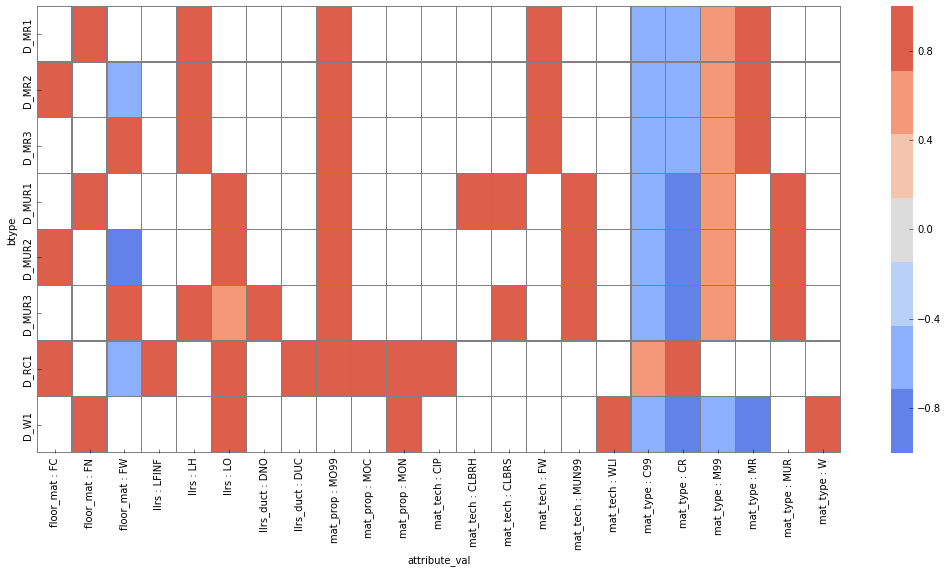

In [10]:

wgs_destress = collections.OrderedDict()

wgs_destress['mat_type'] = 0.35
wgs_destress['mat_tech'] = 0.2
wgs_destress['mat_prop'] = 0.05
wgs_destress['llrs'] = 0.2
wgs_destress['llrs_duct'] = 0.1
wgs_destress['floor_mat'] = 0.1

# check if sum of values is "1"
print "sum of values:", sum(wgs_destress.values())

bmod_destress={}

bname = 'D_MUR1'
bmod_destress[bname]={}
bmod_destress[bname]['mat_type']= {'MUR':'+++','M99':'++','CR':'---','C99':'--'}
bmod_destress[bname]['mat_tech']={'MUN99':'+++','CLBRS':'+++','CLBRH':'+++'}
bmod_destress[bname]['mat_prop']={'MO99':'+++'}
bmod_destress[bname]['llrs']={'LO':'+++'}
bmod_destress[bname]['llrs_duct']={}
bmod_destress[bname]['floor_mat']={'FN':'+++'}
bmod_destress[bname]['height_1']={'H_MIN':1,'H_MAX':1}

bname = 'D_MUR2'
bmod_destress[bname]={}
bmod_destress[bname]['mat_type']= {'MUR':'+++','M99':'++','CR':'---','C99':'--'}
bmod_destress[bname]['mat_tech']={'MUN99':'+++'}
bmod_destress[bname]['mat_prop']={'MO99':'+++'}
bmod_destress[bname]['llrs']={'LO':'+++'}
bmod_destress[bname]['llrs_duct']={}
bmod_destress[bname]['floor_mat']={'FC':'+++','FW':'---'}
bmod_destress[bname]['height_1']={'H_MIN':2,'H_MAX':2}

bname = 'D_MUR3' 
bmod_destress[bname]={}
bmod_destress[bname]['mat_type']= {'MUR':'+++','M99':'++','CR':'---','C99':'--'}
bmod_destress[bname]['mat_tech']={'MUN99':'+++','CLBRS':'+++'}
bmod_destress[bname]['mat_prop']={'MO99':'+++'}
bmod_destress[bname]['llrs']={'LH':'+++','LO':'++'}
bmod_destress[bname]['llrs_duct']={'DNO':'+++'}
bmod_destress[bname]['floor_mat']={'FW':'+++'}
bmod_destress[bname]['height_1']={'H_MIN':2,'H_MAX':2}

bname = 'D_MR1' 
bmod_destress[bname]={}
bmod_destress[bname]['mat_type']= {'MR':'+++','M99':'++','CR':'--','C99':'--'}
bmod_destress[bname]['mat_tech']={'FW':'+++'}
bmod_destress[bname]['mat_prop']={'MO99':'+++'}
bmod_destress[bname]['llrs']={'LH':'+++'}
bmod_destress[bname]['llrs_duct']={}
bmod_destress[bname]['floor_mat']={'FN':'+++'}
bmod_destress[bname]['height_1']={'H_MIN':1,'H_MAX':1}

bname = 'D_MR3' 
bmod_destress[bname]={}
bmod_destress[bname]['mat_type']= {'MR':'+++','M99':'++','CR':'--','C99':'--'}
bmod_destress[bname]['mat_tech']={'FW':'+++'}
bmod_destress[bname]['mat_prop']={'MO99':'+++'}
bmod_destress[bname]['llrs']={'LH':'+++'}
bmod_destress[bname]['llrs_duct']={}
bmod_destress[bname]['floor_mat']={'FW':'+++'}
bmod_destress[bname]['height_1']={'H_MIN':2,'H_MAX':2}

bname = 'D_MR2' 
bmod_destress[bname]={}
bmod_destress[bname]['mat_type']= {'MR':'+++','M99':'++','CR':'--','C99':'--'}
bmod_destress[bname]['mat_tech']={'FW':'+++'}
bmod_destress[bname]['mat_prop']={'MO99':'+++'}
bmod_destress[bname]['llrs']={'LH':'+++'}
bmod_destress[bname]['llrs_duct']={}
bmod_destress[bname]['floor_mat']={'FC':'+++','FW':'--'}
bmod_destress[bname]['height_1']={'H_MIN':2,'H_MAX':2}

bname = 'D_RC1' 
bmod_destress[bname]={}
bmod_destress[bname]['mat_type']= {'CR':'+++','C99':'++'}
bmod_destress[bname]['mat_tech']={'CIP':'+++'}
bmod_destress[bname]['mat_prop']={'MOC':'+++','MON':'+++','MO99':'+++'}
bmod_destress[bname]['llrs']={'LFINF':'+++','LO':'+++'}
bmod_destress[bname]['llrs_duct']={'DUC':'+++'}
bmod_destress[bname]['floor_mat']={'FC':'+++','FW':'--'}
bmod_destress[bname]['height_1']={'H_MIN':1,'H_MAX':5}

bname = 'D_W1' 
bmod_destress[bname]={}
bmod_destress[bname]['mat_type']= {'W':'+++','CR':'---','C99':'--','MR':'---','M99':'--',}
bmod_destress[bname]['mat_tech']={'WLI':'+++'}
bmod_destress[bname]['mat_prop']={'MON':'+++'}
bmod_destress[bname]['llrs']={'LO':'+++'}
bmod_destress[bname]['llrs_duct']={}
bmod_destress[bname]['floor_mat']={'FN':'+++'}
bmod_destress[bname]['height_1']={'H_MIN':1,'H_MAX':1}

#serialize bmod class
bmod_destress_meta = collections.OrderedDict()
bmod_destress_meta['name'] = 'bmod_destress'
bmod_destress_meta['description'] = 'definition of DESTRESS building types, using fuzzy compatibility formulation'
bmod_destress_meta['version'] = '1.0'
bmod_destress_meta['classes'] = bmod_destress.keys()
bmod_destress_meta['weights'] = wgs_destress
bmod_destress_meta['fuzzy_values'] = mf
bmod_destress_meta['definition']= bmod_destress

#save file ? 
#outf = "path/filename.yml"
#exportClassDict(bmod_destress_meta,outf,output_format='json')

#let us plot the schema
plot_bclass_schema(bmod_destress,wgs_destress,mf)

### Test on an individual building

We can test the fuzzy scoring procedure on a single building from the 'Alsace' dataset loaded from file. 

In the following cell the first building of the dataset will be selected, and its structural fetures listed. 

Then we will evaluate the set of compatibility scores of the considered buildings with respect to the two class definition schemas (EMS-98 and DESTRESS). 


In [16]:
bdg = bdg_df_destress.loc[1]
#print the observed feastures of the considered building 
print bdg


lon               7.92277
lat               48.9143
object_id           21123
mat_type              MUR
mat_tech             ST99
mat_prop              MOC
llrs                   LO
llrs_duct            DU99
height                  H
height_1                2
yr_built             YAPP
occupy                RES
occupy_dt            RES1
str_irreg            IRRE
str_irreg_dt        IRP99
str_irreg_type        IRN
roof_shape           RSH4
roofcovmat           RMT1
roofsysmat            RWO
roofsystyp           RWO1
roof_conn            RTDP
floor_mat              FC
floor_type           FT99
floor_conn           FWCP
position              BPD
plan_shape           PLFR
Name: 1, dtype: object


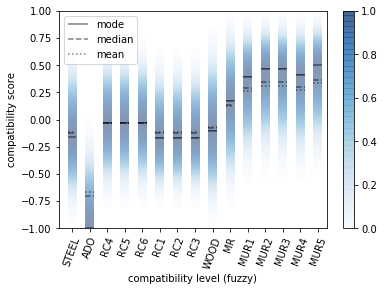

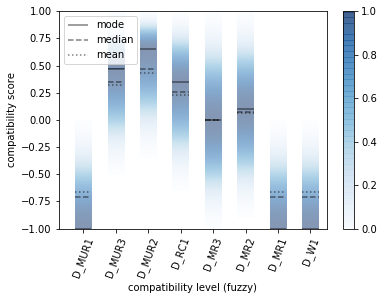

In [17]:

#compute the scores of the considered building with respect to the EMS-98 class definition schema, and plot them
s_ems98 = [compute_single_bscore_fuzzy(bdg,bt,wgs_ems98, bmod_schema_ems98, mf) for bt in bmod_schema_ems98.keys()]
plot_fnum_vec(s_ems98,bmod_schema_ems98.keys(),'',rot=70,loc='upper left')

#compute the scores of the considered building with respect to the DESTRESS class definition schema, and plot them
s_destress = [compute_single_bscore_fuzzy(bdg,bt,wgs_destress, bmod_destress, mf) for bt in bmod_destress.keys()]
plot_fnum_vec(s_destress,bmod_destress.keys(),'',rot=70,loc='upper left')




## Compute the exposure model according to the DESTRESS class definition schema

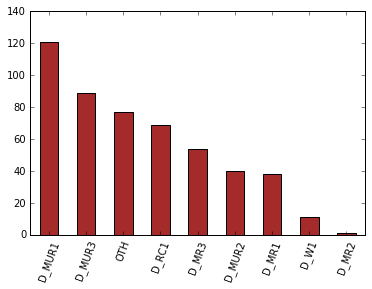

In [14]:
cl_destress, cl_destress_scores = compute_expo_model_fuzzy(bdg_df_destress,wgs_destress,
                                                   bmod_destress,mf,bFilterScore = True,bFilterScoreThreshold = 0.0)

cl_destress['btype'].value_counts().plot(kind='bar',rot=70,color='brown')


## Compute the exposure model according to the EMS-98 class definition schema


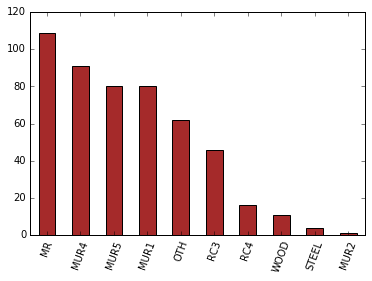

In [15]:
cl_ems98, cl_ems98_scores = compute_expo_model_fuzzy(bdg_df_destress,wgs_ems98,
                                                   bmod_schema_ems98,mf,bFilterScore = True,bFilterScoreThreshold = 0.0)

cl_ems98['btype'].value_counts().plot(kind='bar',rot=70,color='brown')
